In [124]:
import pandas as pd

data = pd.read_csv('merged_data.csv', parse_dates=['timestamp'])

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212066 entries, 0 to 212065
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         212066 non-null  int64         
 1   timestamp          212066 non-null  datetime64[ns]
 2   demand             186142 non-null  float64       
 3   city               212066 non-null  object        
 4   precipIntensity    211776 non-null  float64       
 5   precipProbability  211776 non-null  float64       
 6   temperature        212053 non-null  float64       
 7   humidity           212053 non-null  float64       
 8   pressure           211997 non-null  float64       
 9   windSpeed          211999 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 16.2+ MB


# Handling missing data

In [126]:
# Check total and percentage of missing values in each column
missing_info = data.isnull().sum().to_frame(name='Missing Count')
missing_info['Total Rows'] = len(data)
missing_info['Missing %'] = (missing_info['Missing Count'] / missing_info['Total Rows']) * 100
print(missing_info)


                   Missing Count  Total Rows  Missing %
Unnamed: 0                     0      212066   0.000000
timestamp                      0      212066   0.000000
demand                     25924      212066  12.224496
city                           0      212066   0.000000
precipIntensity              290      212066   0.136750
precipProbability            290      212066   0.136750
temperature                   13      212066   0.006130
humidity                      13      212066   0.006130
pressure                      69      212066   0.032537
windSpeed                     67      212066   0.031594


In [127]:
# dropping rows where demand is missing
data = data.dropna(subset=['demand'])

# Check total and percentage of missing values in each column
missing_info = data.isnull().sum().to_frame(name='Missing Count')
missing_info['Total Rows'] = len(data)
missing_info['Missing %'] = (missing_info['Missing Count'] / missing_info['Total Rows']) * 100
print(missing_info)


                   Missing Count  Total Rows  Missing %
Unnamed: 0                     0      186142   0.000000
timestamp                      0      186142   0.000000
demand                         0      186142   0.000000
city                           0      186142   0.000000
precipIntensity              198      186142   0.106370
precipProbability            198      186142   0.106370
temperature                    9      186142   0.004835
humidity                       9      186142   0.004835
pressure                      46      186142   0.024712
windSpeed                     45      186142   0.024175


In [128]:
# Columns to interpolate
weather_cols = ['precipIntensity', 'precipProbability', 'temperature', 'humidity', 'pressure', 'windSpeed']

# Function to interpolate weather columns with time-based method
def interpolate_weather(group):
    group = group.set_index('timestamp')
    group[weather_cols] = group[weather_cols].interpolate(method='time')
    return group.reset_index()

# Apply per city group
data = data.groupby('city').apply(interpolate_weather).reset_index(drop=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_18908\2092347414.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('city').apply(interpolate_weather).reset_index(drop=True)


In [129]:
# Check total and percentage of missing values in each column
missing_info = data.isnull().sum().to_frame(name='Missing Count')
missing_info['Total Rows'] = len(data)
missing_info['Missing %'] = (missing_info['Missing Count'] / missing_info['Total Rows']) * 100
print(missing_info)


                   Missing Count  Total Rows  Missing %
timestamp                      0      186142        0.0
Unnamed: 0                     0      186142        0.0
demand                         0      186142        0.0
city                           0      186142        0.0
precipIntensity                0      186142        0.0
precipProbability              0      186142        0.0
temperature                    0      186142        0.0
humidity                       0      186142        0.0
pressure                       0      186142        0.0
windSpeed                      0      186142        0.0


# Feature engineering

**Extract Time Features**

In [130]:
# Extract time-based features
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year

# Define a function for season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['season'] = data['month'].apply(get_season)


In [131]:
data.head()

,timestamp,Unnamed: 0,demand,city,precipIntensity,precipProbability,temperature,humidity,pressure,windSpeed,hour,day_of_week,month,year,season
0,2019-05-27 01:00:00,96549,12432.0,dallas,0.0015,0.01,84.66,0.58,1013.8,10.83,1,0,5,2019,Spring
1,2019-05-27 02:00:00,96550,11662.0,dallas,0.0013,0.01,82.19,0.64,1013.7,10.31,2,0,5,2019,Spring
2,2019-05-27 03:00:00,96551,11164.0,dallas,0.0012,0.01,80.25,0.70,1013.5,10.01,3,0,5,2019,Spring
3,2019-05-27 04:00:00,96552,10768.0,dallas,0.0009,0.01,79.52,0.72,1013.2,10.92,4,0,5,2019,Spring
4,2019-05-27 05:00:00,96553,10565.0,dallas,0.0000,0.00,78.87,0.74,1013.1,10.65,5,0,5,2019,Spring


In [132]:
city_counts_by_year = data.groupby('year')['city'].value_counts()
print(city_counts_by_year)


year  city        
2018  phoenix          4399
      seattle          4398
      dallas           4379
      houston          4379
      nyc              4379
      san antonio      4379
      la               4373
      san diego        4373
      san jose         4373
      philadelphia     2660
2019  dallas          14016
      houston         14016
      san antonio     14016
      nyc              8760
      phoenix          8760
      philadelphia     8735
      seattle          8734
      la               8684
      san diego        8684
      san jose         8684
2020  dallas           6239
      houston          6239
      san antonio      6239
      la               3358
      san diego        3358
      san jose         3358
      nyc              3336
      philadelphia     3313
      phoenix          2761
      seattle          2760
Name: count, dtype: int64


**Detect & Handle Outliers**

In [133]:
from sklearn.ensemble import IsolationForest

# Use only numeric features
features = data.select_dtypes(include='number')

# Fit the model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_preds = iso_forest.fit_predict(features)

# Add result to the data
data['anomaly'] = outlier_preds  # -1 = anomaly, 1 = normal

# Correct filtering (same DataFrame used)
data_clean = data[data['anomaly'] == 1].drop(columns='anomaly')


In [134]:
data_clean

,timestamp,Unnamed: 0,demand,city,precipIntensity,precipProbability,temperature,humidity,pressure,windSpeed,hour,day_of_week,month,year,season
0,2019-05-27 01:00:00,96549,12432.0,dallas,0.0015,0.01,84.66,0.58,1013.8,10.83,1,0,5,2019,Spring
1,2019-05-27 02:00:00,96550,11662.0,dallas,0.0013,0.01,82.19,0.64,1013.7,10.31,2,0,5,2019,Spring
2,2019-05-27 03:00:00,96551,11164.0,dallas,0.0012,0.01,80.25,0.70,1013.5,10.01,3,0,5,2019,Spring
3,2019-05-27 04:00:00,96552,10768.0,dallas,0.0009,0.01,79.52,0.72,1013.2,10.92,4,0,5,2019,Spring
4,2019-05-27 05:00:00,96553,10565.0,dallas,0.0000,0.00,78.87,0.74,1013.1,10.65,5,0,5,2019,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186137,2020-04-24 20:00:00,31859,1016.0,seattle,0.0034,0.07,59.28,0.64,1022.3,3.08,20,4,4,2020,Spring
186138,2020-04-24 21:00:00,31860,1014.0,seattle,0.0031,0.05,59.67,0.61,1022.1,4.31,21,4,4,2020,Spring
186139,2020-04-24 22:00:00,31861,976.0,seattle,0.0009,0.02,60.26,0.58,1021.9,4.74,22,4,4,2020,Spring
186140,2020-04-24 23:00:00,31862,923.0,seattle,0.0000,0.00,60.60,0.58,1022.1,5.15,23,4,4,2020,Spring


In [135]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184280 entries, 0 to 186141
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          184280 non-null  datetime64[ns]
 1   Unnamed: 0         184280 non-null  int64         
 2   demand             184280 non-null  float64       
 3   city               184280 non-null  object        
 4   precipIntensity    184280 non-null  float64       
 5   precipProbability  184280 non-null  float64       
 6   temperature        184280 non-null  float64       
 7   humidity           184280 non-null  float64       
 8   pressure           184280 non-null  float64       
 9   windSpeed          184280 non-null  float64       
 10  hour               184280 non-null  int32         
 11  day_of_week        184280 non-null  int32         
 12  month              184280 non-null  int32         
 13  year               184280 non-null  int32        

In [136]:
city_counts_by_year = data_clean.groupby('year')['city'].value_counts()
print(city_counts_by_year)


year  city        
2018  phoenix          4399
      san jose         4372
      san diego        4362
      la               4361
      seattle          4315
      houston          4300
      san antonio      4289
      dallas           4221
      nyc              4170
      philadelphia     2527
2019  houston         13974
      san antonio     13966
      dallas          13941
      phoenix          8746
      seattle          8690
      san jose         8678
      philadelphia     8661
      san diego        8653
      la               8641
      nyc              8614
2020  houston          6186
      san antonio      6162
      dallas           6086
      la               3349
      san diego        3343
      san jose         3336
      nyc              3286
      philadelphia     3257
      phoenix          2741
      seattle          2654
Name: count, dtype: int64


**Normalize / Scale Continuous Features**

In [137]:
from sklearn.preprocessing import MinMaxScaler
continuous_cols = ['precipIntensity' , 'precipProbability' ,'temperature', 'humidity' ,'pressure', 'windSpeed']
scaler = MinMaxScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])


In [138]:
data

,timestamp,Unnamed: 0,demand,city,precipIntensity,precipProbability,temperature,humidity,pressure,windSpeed,hour,day_of_week,month,year,season,anomaly
0,2019-05-27 01:00:00,96549,12432.0,dallas,0.001211,0.01,0.734088,0.58,0.566616,0.396703,1,0,5,2019,Spring,1
1,2019-05-27 02:00:00,96550,11662.0,dallas,0.001050,0.01,0.711725,0.64,0.565084,0.377656,2,0,5,2019,Spring,1
2,2019-05-27 03:00:00,96551,11164.0,dallas,0.000969,0.01,0.694160,0.70,0.562021,0.366667,3,0,5,2019,Spring,1
3,2019-05-27 04:00:00,96552,10768.0,dallas,0.000727,0.01,0.687551,0.72,0.557427,0.400000,4,0,5,2019,Spring,1
4,2019-05-27 05:00:00,96553,10565.0,dallas,0.000000,0.00,0.681666,0.74,0.555896,0.390110,5,0,5,2019,Spring,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186137,2020-04-24 20:00:00,31859,1016.0,seattle,0.002745,0.07,0.504301,0.64,0.696784,0.112821,20,4,4,2020,Spring,1
186138,2020-04-24 21:00:00,31860,1014.0,seattle,0.002503,0.05,0.507832,0.61,0.693721,0.157875,21,4,4,2020,Spring,1
186139,2020-04-24 22:00:00,31861,976.0,seattle,0.000727,0.02,0.513173,0.58,0.690658,0.173626,22,4,4,2020,Spring,1
186140,2020-04-24 23:00:00,31862,923.0,seattle,0.000000,0.00,0.516252,0.58,0.693721,0.188645,23,4,4,2020,Spring,1


In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186142 entries, 0 to 186141
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          186142 non-null  datetime64[ns]
 1   Unnamed: 0         186142 non-null  int64         
 2   demand             186142 non-null  float64       
 3   city               186142 non-null  object        
 4   precipIntensity    186142 non-null  float64       
 5   precipProbability  186142 non-null  float64       
 6   temperature        186142 non-null  float64       
 7   humidity           186142 non-null  float64       
 8   pressure           186142 non-null  float64       
 9   windSpeed          186142 non-null  float64       
 10  hour               186142 non-null  int32         
 11  day_of_week        186142 non-null  int32         
 12  month              186142 non-null  int32         
 13  year               186142 non-null  int32   

In [140]:
print(data['city'].value_counts())


city
dallas          24634
houston         24634
san antonio     24634
nyc             16475
la              16415
san diego       16415
san jose        16415
phoenix         15920
seattle         15892
philadelphia    14708
Name: count, dtype: int64


**Categorical Encoding**

In [141]:
Data = pd.get_dummies(data, columns=['city', 'season'], drop_first=False)


In [142]:
Data

,timestamp,Unnamed: 0,demand,precipIntensity,precipProbability,temperature,humidity,pressure,windSpeed,hour,...,city_philadelphia,city_phoenix,city_san antonio,city_san diego,city_san jose,city_seattle,season_Fall,season_Spring,season_Summer,season_Winter
0,2019-05-27 01:00:00,96549,12432.0,0.001211,0.01,0.734088,0.58,0.566616,0.396703,1,...,False,False,False,False,False,False,False,True,False,False
1,2019-05-27 02:00:00,96550,11662.0,0.001050,0.01,0.711725,0.64,0.565084,0.377656,2,...,False,False,False,False,False,False,False,True,False,False
2,2019-05-27 03:00:00,96551,11164.0,0.000969,0.01,0.694160,0.70,0.562021,0.366667,3,...,False,False,False,False,False,False,False,True,False,False
3,2019-05-27 04:00:00,96552,10768.0,0.000727,0.01,0.687551,0.72,0.557427,0.400000,4,...,False,False,False,False,False,False,False,True,False,False
4,2019-05-27 05:00:00,96553,10565.0,0.000000,0.00,0.681666,0.74,0.555896,0.390110,5,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186137,2020-04-24 20:00:00,31859,1016.0,0.002745,0.07,0.504301,0.64,0.696784,0.112821,20,...,False,False,False,False,False,True,False,True,False,False
186138,2020-04-24 21:00:00,31860,1014.0,0.002503,0.05,0.507832,0.61,0.693721,0.157875,21,...,False,False,False,False,False,True,False,True,False,False
186139,2020-04-24 22:00:00,31861,976.0,0.000727,0.02,0.513173,0.58,0.690658,0.173626,22,...,False,False,False,False,False,True,False,True,False,False
186140,2020-04-24 23:00:00,31862,923.0,0.000000,0.00,0.516252,0.58,0.693721,0.188645,23,...,False,False,False,False,False,True,False,True,False,False


In [143]:
Data.to_csv('final_data.csv')

# General Statistics about the data 

In [145]:
# Summary stats for numeric columns
print(data.describe())

# Count of records per city
print(data['city'].value_counts())

# Count of records per season
print(data['season'].value_counts())


                           timestamp     Unnamed: 0         demand  \
count                         186142  186142.000000  186142.000000   
mean   2019-07-01 20:01:04.692546304  111573.390181    7738.735648   
min              2018-07-01 07:00:00       0.000000   -1340.000000   
25%              2019-01-19 12:00:00   57140.250000    3672.000000   
50%              2019-07-17 13:00:00  118781.500000    7024.000000   
75%              2019-12-14 02:00:00  165529.750000   11183.000000   
max              2020-05-20 00:00:00  212065.000000  101412.000000   
std                              NaN   62941.918173    4823.385482   

       precipIntensity  precipProbability    temperature       humidity  \
count    186142.000000      186142.000000  186142.000000  186142.000000   
mean          0.003297           0.056266       0.546310       0.658967   
min           0.000000           0.000000       0.000000       0.000000   
25%           0.000000           0.000000       0.443096       0.5100

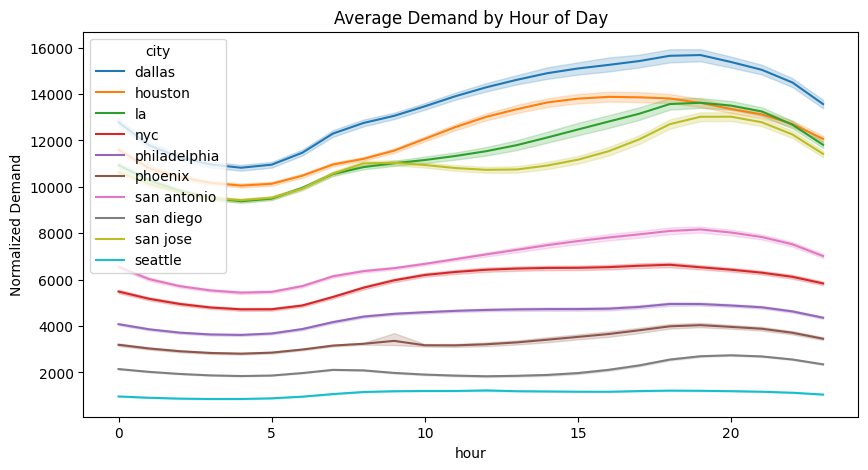

In [146]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x='hour', y='demand', hue='city', estimator='mean')
plt.title('Average Demand by Hour of Day')
plt.ylabel('Normalized Demand')
plt.show()
